In [26]:
import tensorflow as tf
import numpy as np 
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt

In [3]:
mnist_base_path="/Users/zhouwencheng/Desktop/Grass/data/picture/mnist"
# 载入数据集
mnist = input_data.read_data_sets(mnist_base_path, one_hot=True)

Extracting ./data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [59]:
# Parameter
learning_rate = 0.01
training_epochs = 20 # 五组训练
batch_size = 256
display_step = 1
examples_to_show = 10

keep_prob = 1

# Network Parameters
n_input = 784  # MNIST data input (img shape: 28*28)

In [49]:
# 随机加入噪声
def get_corrupted(x, corruption_level):
    # the shape of input
    input_shape = np.shape(x)
    # the probablity for corruption
    probs = tf.tile(tf.log([[corruption_level, 1-corruption_level]]),
                    multiples=[input_shape[0], 1])
    return tf.multiply(tf.cast(tf.multinomial(probs, num_samples=input_shape[1]),
                              dtype=np.float32), x)

In [50]:
# hidden layer settings
n_hidden_1 = 128 # 1st layer num features
n_hidden_2 = 64 # 2nd layer num features
weights = {
    'encoder_h1':tf.Variable(tf.random_normal([n_input,n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1,n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2,n_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
    }

biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([n_input])),
    }

In [61]:
# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    
#     ly_1_dorp = tf.nn.dropout(layer_1, keep_prob = keep_prob)
    
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    
#     ly_2_dorp = tf.nn.dropout(layer_2, keep_prob = keep_prob)
        
    return layer_2
    
# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

In [62]:
x = tf.placeholder(dtype=tf.float32, shape=[None, 28*28])  

# Construct model
encoder_op = encoder(x) # 128 Features
decoder_op = decoder(encoder_op) # 784 Features

# Prediction
y_pred = decoder_op	# After 
# Targets (Labels) are the input data.
y_true = x  # Before

In [63]:
# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
# cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

Epoch: 0001 cost= 0.067530863
Epoch: 0002 cost= 0.053345587
Epoch: 0003 cost= 0.043510154
Epoch: 0004 cost= 0.040751047
Epoch: 0005 cost= 0.038563866
Epoch: 0006 cost= 0.036280423
Epoch: 0007 cost= 0.034272999
Epoch: 0008 cost= 0.033452641
Epoch: 0009 cost= 0.031730101
Epoch: 0010 cost= 0.031158498
Epoch: 0011 cost= 0.029959029
Epoch: 0012 cost= 0.027669435
Epoch: 0013 cost= 0.027334772
Epoch: 0014 cost= 0.028075764
Epoch: 0015 cost= 0.025052914
Epoch: 0016 cost= 0.027225124
Epoch: 0017 cost= 0.025362469
Epoch: 0018 cost= 0.024393000
Epoch: 0019 cost= 0.023387186
Epoch: 0020 cost= 0.024117328
Optimization Finished!


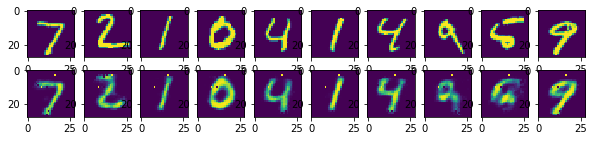

In [64]:
# Launch the graph
with tf.Session() as sess:
    # tf 马上就要废弃tf.initialize_all_variables()这种写法
    # 替换成下面:
    sess.run(tf.global_variables_initializer())
    total_batch = int(mnist.train.num_examples/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)  # max(x) = 1, min(x) = 0
            # Run optimization op (backprop) and cost op (to get loss value)
            
#             batch_xs = get_corrupted(batch_xs, 0.2).eval()
            
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_xs})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))

    print("Optimization Finished!")
    
    # # Applying encode and decode over test set
    encode_decode = sess.run(
        y_pred, feed_dict={x: mnist.test.images[:examples_to_show]})
    # Compare original images with their reconstructions
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(examples_to_show):
        a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
        a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
    plt.show()